### imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho da pasta "Twitch"
base_dir = Path(os.getcwd()).resolve().parent  # Ajuste se necessário

# Adicionar as pasta ao sys.path
visualization_dir = base_dir / 'src' / 'visualization'
getData_dir = base_dir / 'src' / 'data'
sys.path.append(str(visualization_dir))
sys.path.append(str(getData_dir))

# Importar os módulos
try:
    import community_visualization
    import correlations
    import TwitchGraphs
    import TwitchVisualization
except ImportError:
    print("Erro: Não foi possível importar algum módulo. Verifique se o caminho está correto.")

# Paises
countries = ["PTBR", "DE", "ENGB", "ES", "FR", "RU"]

## Visualização das correlações

#### Selecionar o País

In [2]:
# Escolher entre: DE, ENGB, ES, FR, PTBR, RU
country = "RU"

#### Definir o diretório correto

In [3]:
# Carregar dados
csv_path = base_dir / 'data' / country / 'processed_data' / f"twitch_network_analysis_{country}.csv"
output_dir = base_dir / 'docs' / "Imagens"
output_dir.mkdir(exist_ok=True)

# Ler dados
df = pd.read_csv(csv_path)
df.head()

,node,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,...,created_at,profile_pic,broadcaster_type,game_name,day_of_year,is_leap,days_in_year,normalized_day,sin_created_at,cos_created_at
0,1076,6,0.001369,0.308342,0.000468,0.001220,0.000143,0.133333,6,0,...,2013-05-17,https://static-cdn.jtvnw.net/jtv_user_pictures...,non_Streamer,World of Warcraft,137.0,False,365,2.341132,0.717677,-0.696376
1,1090,1,0.000228,0.256945,0.000000,0.000051,0.000050,0.000000,6,0,...,2012-07-21,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Minion Masters,203.0,True,366,3.467769,-0.320423,-0.947274
2,633,45,0.010265,0.392972,0.001281,0.016432,0.000529,0.105051,1,0,...,2016-01-16,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Sea of Thieves,16.0,True,366,0.257508,0.254671,0.967028
3,2238,8,0.001825,0.372599,0.000172,0.008873,0.000125,0.250000,2,0,...,2014-01-07,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Mir Tankov,7.0,False,365,0.103285,0.103102,0.994671
4,1662,11,0.002509,0.359846,0.000056,0.006519,0.000153,0.145455,3,0,...,2014-10-12,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Project Zomboid,285.0,False,365,4.888835,-0.984474,0.175531


### Arranjar o tipo das variáveis

In [4]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d')
df['created_year'] = df['created_at'].dt.year
df['mature'] = df['mature'].astype(int)
df['partner'] = df['partner'].astype(int)
df = df.drop(columns=['id', 'node', 'new_id', 'username', 'profile_pic', 'created_at', 'day_of_year', 'normalized_day', 'is_leap', 'days_in_year'])
df.head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,days,mature,views,partner,broadcaster_type,game_name,sin_created_at,cos_created_at,created_year
0,6,0.001369,0.308342,0.000468,0.001220,0.000143,0.133333,6,0,4225,0,2002,0,non_Streamer,World of Warcraft,0.717677,-0.696376,2013.0
1,1,0.000228,0.256945,0.000000,0.000051,0.000050,0.000000,6,0,4525,1,1885,0,affiliate,Minion Masters,-0.320423,-0.947274,2012.0
2,45,0.010265,0.392972,0.001281,0.016432,0.000529,0.105051,1,0,3251,0,14538,0,affiliate,Sea of Thieves,0.254671,0.967028,2016.0
3,8,0.001825,0.372599,0.000172,0.008873,0.000125,0.250000,2,0,3990,1,8541,0,affiliate,Mir Tankov,0.103102,0.994671,2014.0
4,11,0.002509,0.359846,0.000056,0.006519,0.000153,0.145455,3,0,3712,0,49854,0,affiliate,Project Zomboid,-0.984474,0.175531,2014.0


In [5]:
df.dtypes

degree                      int64
degree_centrality         float64
closeness_centrality      float64
betweenness_centrality    float64
eigenvector_centrality    float64
pagerank_centrality       float64
clustering_coef           float64
louvain_community           int64
lp_community                int64
days                        int64
mature                      int64
views                       int64
partner                     int64
broadcaster_type           object
game_name                  object
sin_created_at            float64
cos_created_at            float64
created_year              float64
dtype: object

#### Games

In [6]:
# Lista de categorias que NÃO são jogos
nao_jogos = ['IRL', 'Just Chatting', 'Watch TV']

df['isGame'] = df['game_name'].apply(
    lambda x: -1 if pd.isna(x) else (0 if x in nao_jogos else 1)
)


In [7]:
df.head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,days,mature,views,partner,broadcaster_type,game_name,sin_created_at,cos_created_at,created_year,isGame
0,6,0.001369,0.308342,0.000468,0.001220,0.000143,0.133333,6,0,4225,0,2002,0,non_Streamer,World of Warcraft,0.717677,-0.696376,2013.0,1
1,1,0.000228,0.256945,0.000000,0.000051,0.000050,0.000000,6,0,4525,1,1885,0,affiliate,Minion Masters,-0.320423,-0.947274,2012.0,1
2,45,0.010265,0.392972,0.001281,0.016432,0.000529,0.105051,1,0,3251,0,14538,0,affiliate,Sea of Thieves,0.254671,0.967028,2016.0,1
3,8,0.001825,0.372599,0.000172,0.008873,0.000125,0.250000,2,0,3990,1,8541,0,affiliate,Mir Tankov,0.103102,0.994671,2014.0,1
4,11,0.002509,0.359846,0.000056,0.006519,0.000153,0.145455,3,0,3712,0,49854,0,affiliate,Project Zomboid,-0.984474,0.175531,2014.0,1


### Categoricas


In [8]:
# Broadcaster Type em uma variavel categorica
df['broadcaster_type'] = df['broadcaster_type'].astype('category')
df['louvain_community'] =  df['louvain_community'].astype('category')
df['lp_community'] =  df['lp_community'].astype('category')
df['partner'] =  df['partner'].astype('category')
df['game_name'] =  df['game_name'].astype('category')
df['mature'] =  df['mature'].astype('category')
df['isGame'] =  df['isGame'].astype('category')


#### Variáveis Extras

In [9]:
df.dtypes


degree                       int64
degree_centrality          float64
closeness_centrality       float64
betweenness_centrality     float64
eigenvector_centrality     float64
pagerank_centrality        float64
clustering_coef            float64
louvain_community         category
lp_community              category
days                         int64
mature                    category
views                        int64
partner                   category
broadcaster_type          category
game_name                 category
sin_created_at             float64
cos_created_at             float64
created_year               float64
isGame                    category
dtype: object

In [10]:
df.head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,days,mature,views,partner,broadcaster_type,game_name,sin_created_at,cos_created_at,created_year,isGame
0,6,0.001369,0.308342,0.000468,0.001220,0.000143,0.133333,6,0,4225,0,2002,0,non_Streamer,World of Warcraft,0.717677,-0.696376,2013.0,1
1,1,0.000228,0.256945,0.000000,0.000051,0.000050,0.000000,6,0,4525,1,1885,0,affiliate,Minion Masters,-0.320423,-0.947274,2012.0,1
2,45,0.010265,0.392972,0.001281,0.016432,0.000529,0.105051,1,0,3251,0,14538,0,affiliate,Sea of Thieves,0.254671,0.967028,2016.0,1
3,8,0.001825,0.372599,0.000172,0.008873,0.000125,0.250000,2,0,3990,1,8541,0,affiliate,Mir Tankov,0.103102,0.994671,2014.0,1
4,11,0.002509,0.359846,0.000056,0.006519,0.000153,0.145455,3,0,3712,0,49854,0,affiliate,Project Zomboid,-0.984474,0.175531,2014.0,1


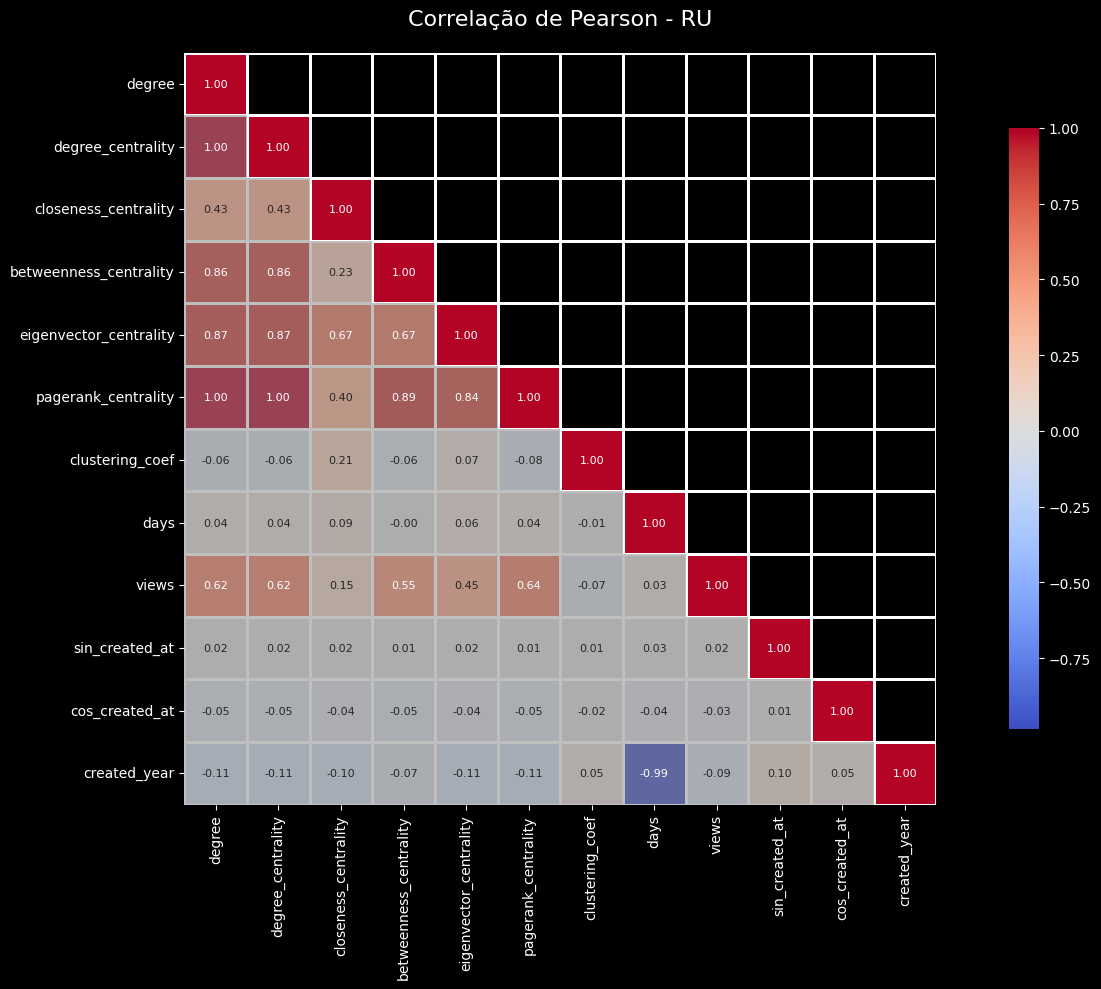

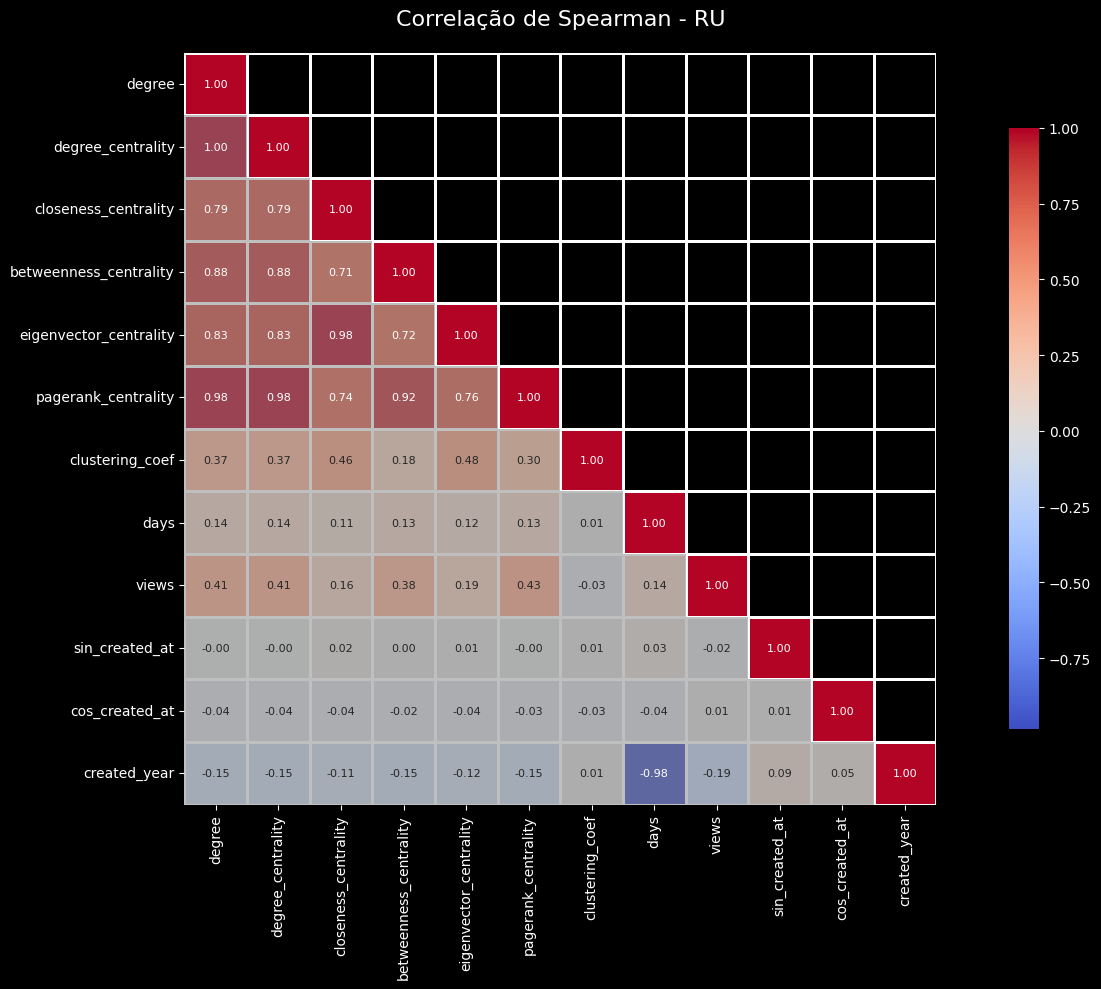

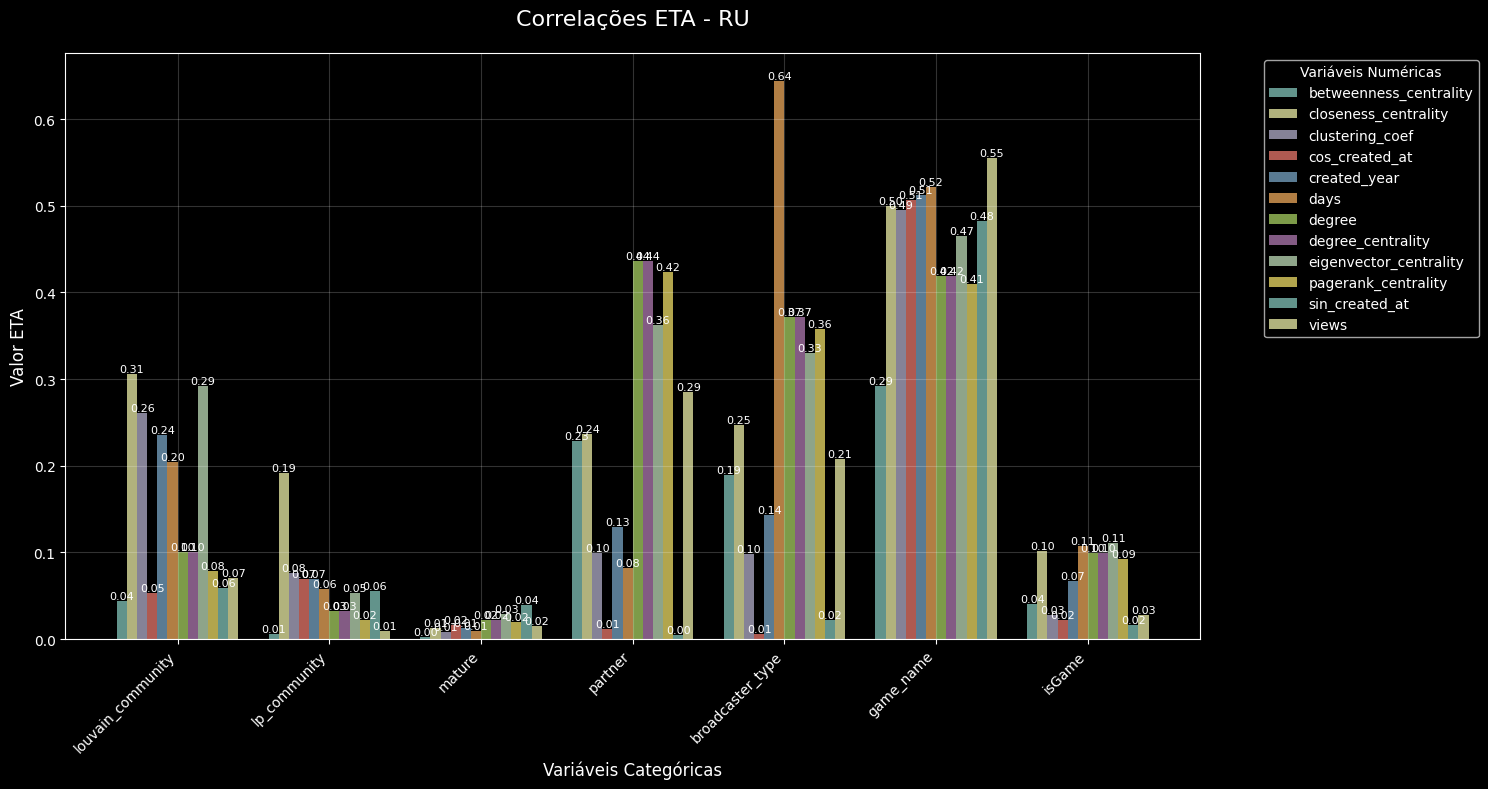

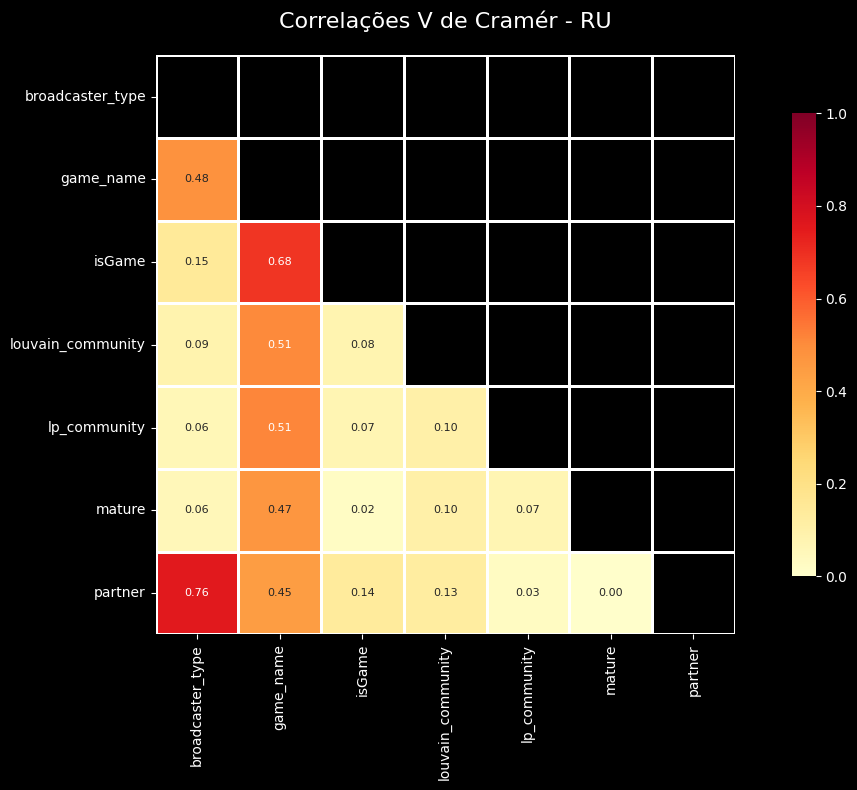

In [11]:
# Calcular correlações
correlations = correlations.calculate_correlations(df, country, output_dir)